In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

source_path = "/backup/kruu/wake_encounter_simulations"

# Encounter parameters

In [13]:
directories = sorted([d for d in os.listdir(os.path.join(source_path, "encounters")) if d.isdigit()])

dataframes = []

for dir_name in directories:
    file_path = os.path.join(source_path, "encounters", dir_name, "param.parquet")
    
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        df['simulation_index'] = int(dir_name)
        dataframes.append(df)

aggregated_params = pd.concat(dataframes, ignore_index=True)

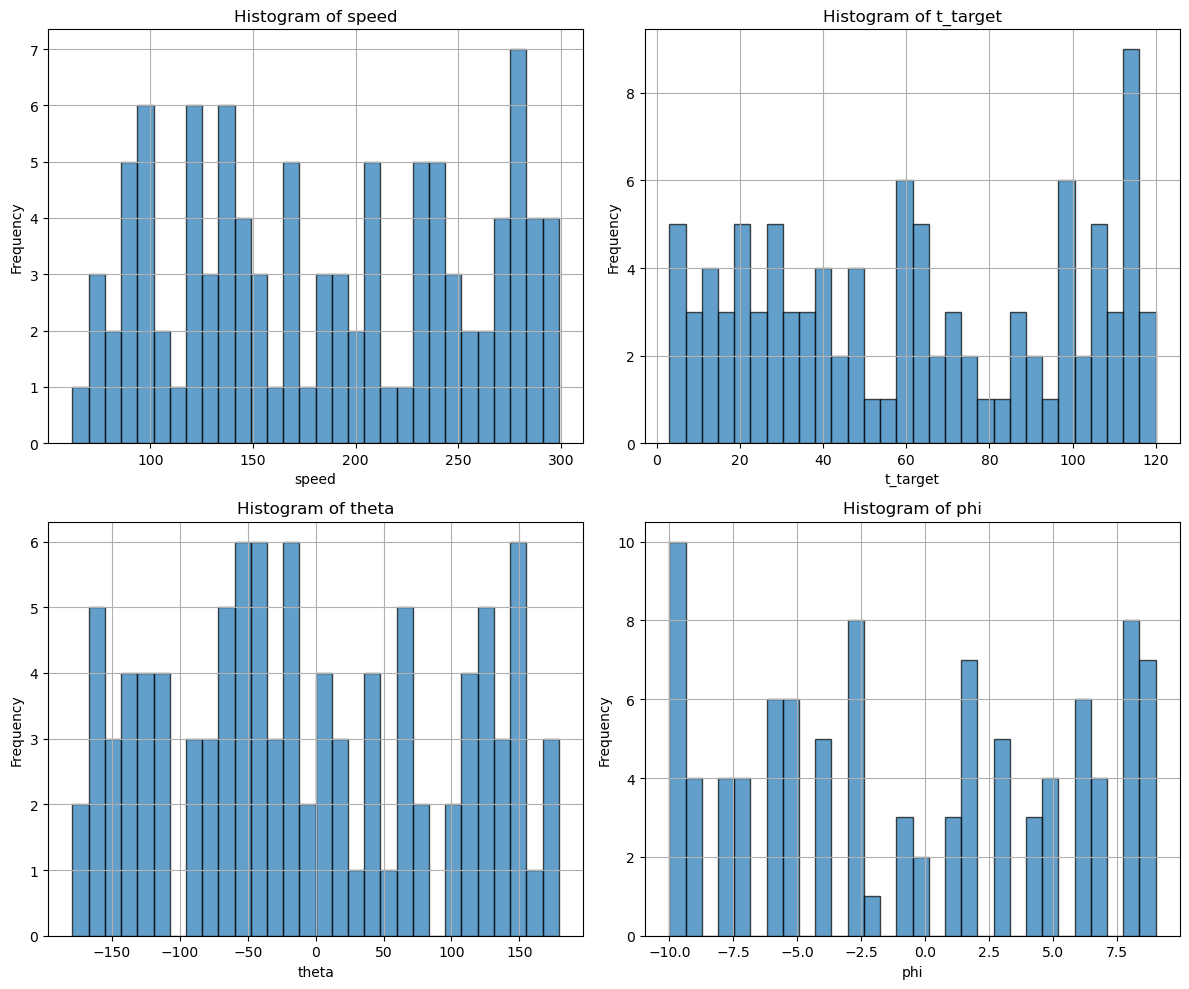

In [19]:
columns_to_plot = ['speed', 't_target', 'theta', 'phi']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

for i, column in enumerate(columns_to_plot):
    if column in aggregated_params.columns:
        axes[i].hist(aggregated_params[column], bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Histogram of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)
    else:
        print(f"Column {column} not found in dataframe.")

plt.tight_layout()
plt.show()


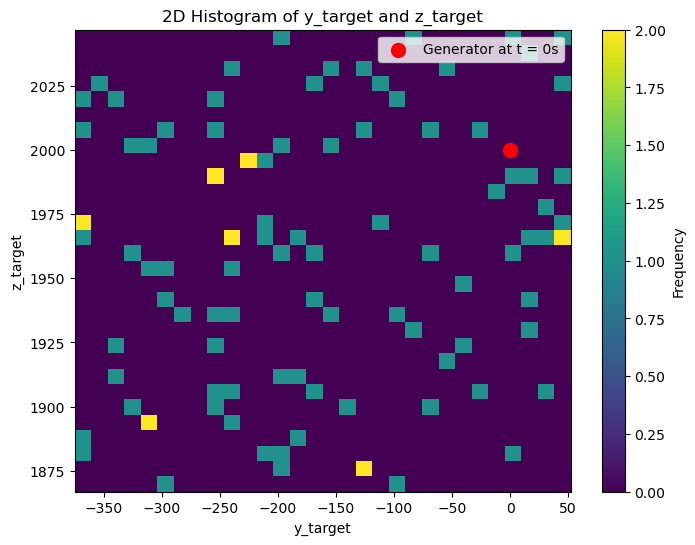

In [21]:
if 'y_target' in aggregated_params.columns and 'z_target' in aggregated_params.columns:
    plt.figure(figsize=(8, 6))
    plt.hist2d(
        aggregated_params['y_target'], 
        aggregated_params['z_target'], 
        bins=30, 
        cmap='viridis'
    )
    plt.colorbar(label='Frequency')
    plt.title('2D Histogram of y_target and z_target')
    plt.xlabel('y_target')
    plt.ylabel('z_target')
    plt.grid(False)
    
    plt.scatter(0, 2000, color='red', label='Generator at t = 0s', s=100)
    plt.legend(loc='upper right')
    plt.show()
else:
    print("Columns 'y_target' and/or 'z_target' not found in dataframe.")


# Wake parameters

In [29]:
sim = aggregated_params["Wake simulation ID"].unique()[0]

# Wake parameters
pd.read_parquet(os.path.join(source_path, "wakes", str(sim), "param.parquet"))

,run_id,alt_aircraft,spread,step,wind_vel,wind_dir,temp,p_ref,tke,speed,mass,wingspan,wind_vertical_vel,alt_sensor,qq,gpa
0,0,2000.0,1000,10,2.0,130.0,288.15,101300.0,10.0,100.0,136000.0,47.3,0.0,10.0,0.05,0.0


# Results

In [ ]:
pd.read_parquet("/backup/kruu/wake_encounter_simulations/encounters/0/A320_0_results.parquet")

In [49]:
directories = sorted([d for d in os.listdir(os.path.join(source_path, "encounters")) if d.isdigit()])

results = {}

for dir_name in directories:
    file_path = os.path.join(source_path, "encounters", dir_name, "A320_" + dir_name + "_results.parquet")
    
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        results[int(dir_name)] = df

In [54]:
forces = ["C_L", "C_D", "C_Y"] #Lift, Drag, Side
moments = ["C_l", "C_m", "C_n"] #rolling, pitching, yawing

sim_to_plot = np.random.choice(100, size=5, replace=False)

# List of dataframes
dataframes = [results[i] for i in sim_to_plot]
labels = sim_to_plot

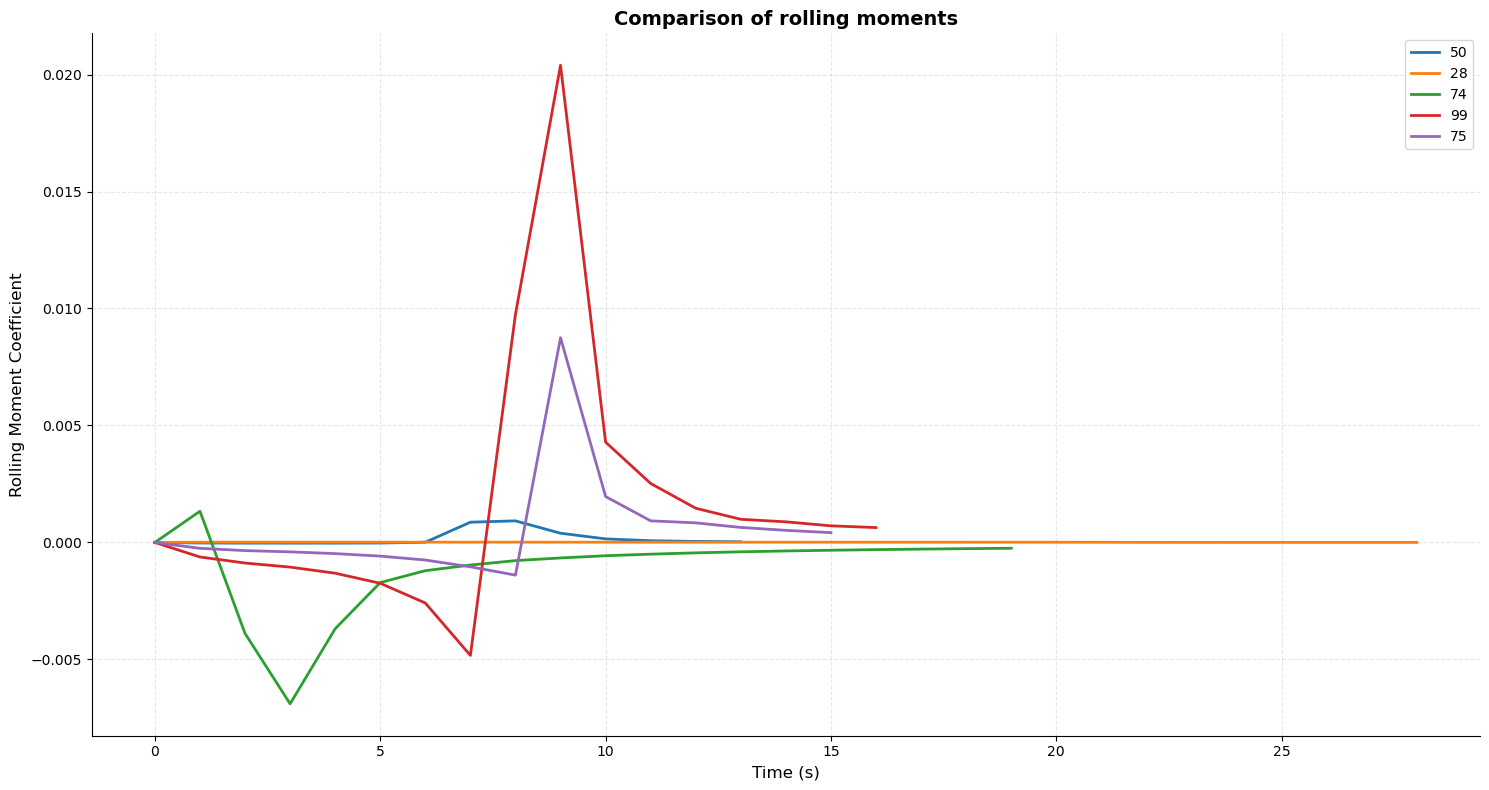

In [58]:
plt.figure(figsize=(15, 8))
plt.grid(alpha=0.3, linestyle='--')

for i, (df, label) in enumerate(zip(dataframes, labels)):
    plt.plot(df["C_l"], label=label, linewidth=2)

plt.legend(title="Scenarios", fontsize='medium', frameon=False)
plt.legend()

# Add labels and title for better clarity
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Rolling Moment Coefficient", fontsize=12)
plt.title("Comparison of rolling moments", fontsize=14, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

# Show the plot
plt.show()


In [93]:
# Calulation of quantiles on the maximum RMC of each simulation

# all_c_l_values = pd.concat([df['C_l'].abs() for df in results.values()])
all_c_l_values = pd.Series([df['C_l'].abs().max() for df in results.values()])
quantiles = all_c_l_values.quantile([0.25, 0.5, 0.75, 0.90, 0.99])
print(quantiles)

keys_above_quantile = [
    key for key, df in results.items()
    if (df['C_l'].abs() >= all_c_l_values.quantile(0.90)).any()
]

severe_encounter = aggregated_params.query(f"simulation_index in {keys_above_quantile}")

0.25    0.001216
0.50    0.004234
0.75    0.013412
0.90    0.033502
0.99    0.059638
dtype: float64


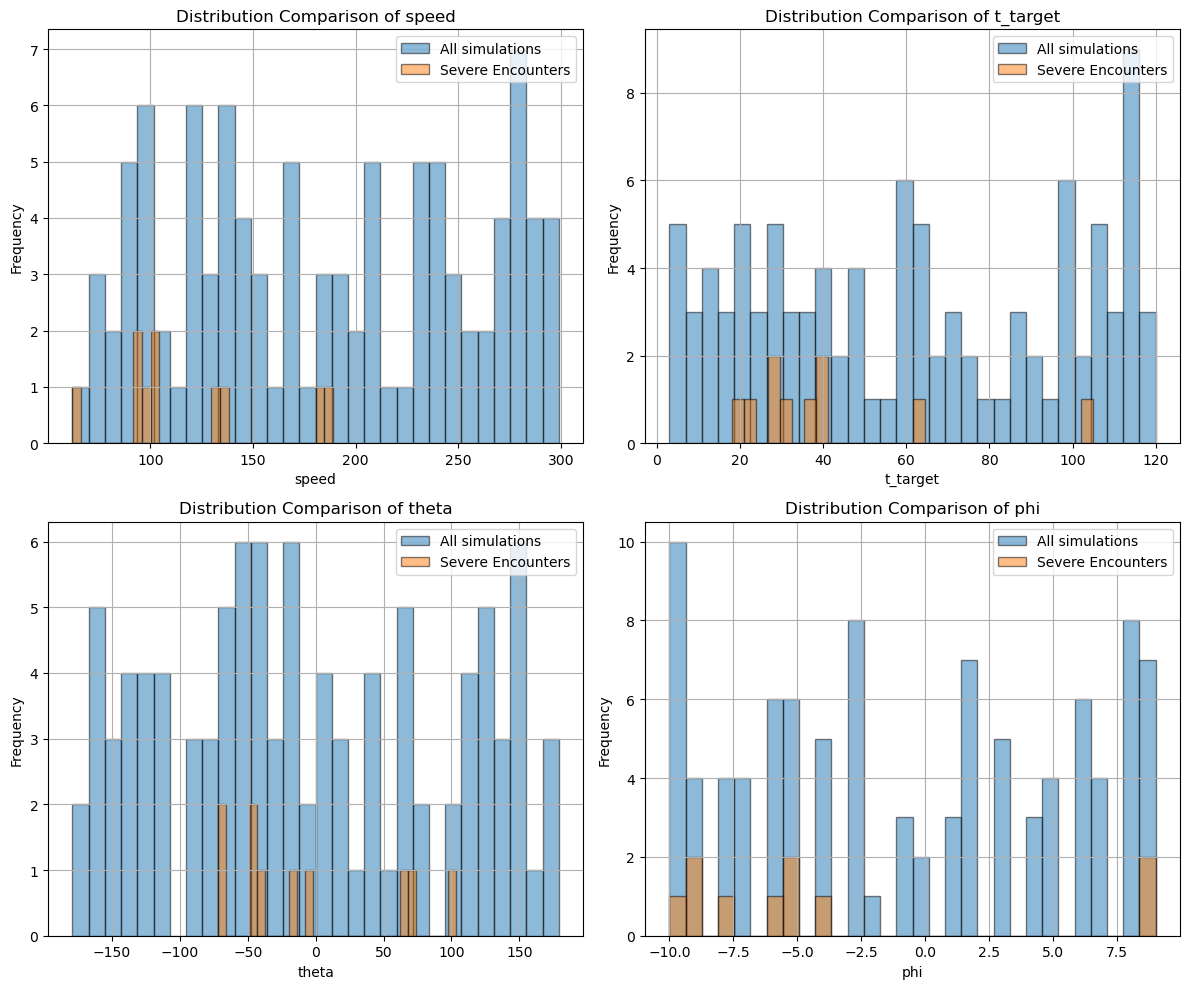

In [94]:
columns_to_plot = ['speed', 't_target', 'theta', 'phi']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

for i, column in enumerate(columns_to_plot):
    if column in aggregated_params.columns and column in severe_encounter.columns:
        axes[i].hist(aggregated_params[column], bins=30, alpha=0.5, label='All simulations', edgecolor='black')
        axes[i].hist(severe_encounter[column], bins=30, alpha=0.5, label='Severe Encounters', edgecolor='black')
        axes[i].set_title(f'Distribution Comparison of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].legend(loc='upper right')
        axes[i].grid(True)
    else:
        print(f"Column {column} not found in dataframe.")

plt.tight_layout()
plt.show()